In [3]:
%load_ext autoreload
%autoreload 2
import os
import sys
from pathlib import Path
import joblib

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from src.Bayesian_state import *
from src.Bayesian_state.problems.config import config_fgt
from src.Bayesian_state.problems import *
# from src.Bayesian_state.utils.optimizer import Optimizer, ConstantDict
# from src.Bayesian_state.utils.model_evaluation import ModelEval

ModuleNotFoundError: No module named 'src.Bayesian_state.problems.partitions_old'

In [ ]:
processed_path = Path(project_root) / 'data' / 'processed'
learning_data = pd.read_csv(processed_path / 'Task2_processed.csv')

subject_id = 17
subject_data = learning_data[learning_data["iSub"] == subject_id]
condition = subject_data["condition"].iloc[0]
s_data = (
    subject_data[["feature1", "feature2", "feature3", "feature4"]].values,
    subject_data["choice"].values,
    subject_data["feedback"].values
)
print(condition)

2


In [ ]:
subject_data.keys()


Index(['iSub', 'version', 'condition', 'structure1', 'structure2', 'iSession',
       'iBlock', 'iTrial', 'neck_length', 'head_length', 'leg_length',
       'tail_length', 'neck_angle', 'head_angle', 'leg_angle', 'tail_angle',
       'feature1', 'feature2', 'feature3', 'feature4', 'category', 'choice',
       'feedback', 'ambigous', 'choRT', 'neck_oral', 'head_oral', 'leg_oral',
       'tail_oral', 'text', 'feature1_oral', 'feature2_oral', 'feature3_oral',
       'feature4_oral', 'neck_use', 'head_use', 'leg_use', 'tail_use',
       'feature1_use', 'feature2_use', 'feature3_use', 'feature4_use'],
      dtype='object')

In [ ]:
from src.Bayesian_state.problems import StandardModel, StateModel
from src.Bayesian_state.utils.load_config import MODEL_STRUCT

# 打印字典并排版
import pprint

choice = 'pm_model'
model = StateModel(MODEL_STRUCT[choice],condition=condition)
pprint.pprint(MODEL_STRUCT[choice])

INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'perception_mod' registered as 'self.perception_mod'.


{'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.5, 'gamma': 0.8}}, 'perception_mod': {'class': 'src.Bayesian_state.problems.modules.perception.PerceptionModule', 'kwargs': {'mean': 0.0, 'std': 0.05}}}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.5, 'gamma': 0.8}
name: perception_mod mod_kwargs: {'mean': 0.0, 'std': 0.05}
{'agenda': ['perception_mod', 'likelihood_mod', 'memory_mod'],
 'modules': {'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule',
                                'kwargs': {'beta': 5.0}},
             'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule',
                            'kwargs': {'gamma': 0.8, 'w0': 0.5}},
             'perception_mod': {'class': 'src.Bayesian_state.p

In [ ]:
# 按trial重整数据
input_data = []
trial_total_num = subject_data.shape[0]
for i in range(trial_total_num):
    input_data.append([s_data[0][i],s_data[1][i], s_data[2][i]])


print(input_data[:5])  # 打印前5个trial

[[array([0.50255826, 0.98811017, 0.77159335, 0.99698384]), np.int64(2), np.float64(0.0)], [array([0.96243671, 0.34515871, 0.80833906, 0.79065973]), np.int64(2), np.float64(0.0)], [array([0.69359518, 0.98701254, 0.21934116, 0.07771833]), np.int64(2), np.float64(0.0)], [array([0.92930833, 0.06842905, 0.72994654, 0.3930689 ]), np.int64(4), np.float64(1.0)], [array([0.20904841, 0.58905002, 0.69392378, 0.48564343]), np.int64(2), np.float64(1.0)]]


In [ ]:
results_state = model.fit_step_by_step(input_data, use_boundary=False)

In [ ]:
np.asarray(results_state).argmax(axis=1)

array([76, 88, 70, 18, 14, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70,
       70, 70, 48, 42, 70, 70, 70, 70, 70, 24, 24, 24, 24, 24, 70, 70, 70,
       48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 42, 42, 42, 42, 42, 42,
       48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 42, 42, 42, 42, 42, 42,
       42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
       42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
       42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
       42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
       42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
       42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
       42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
       42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
       42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
       42, 42, 42, 42, 42

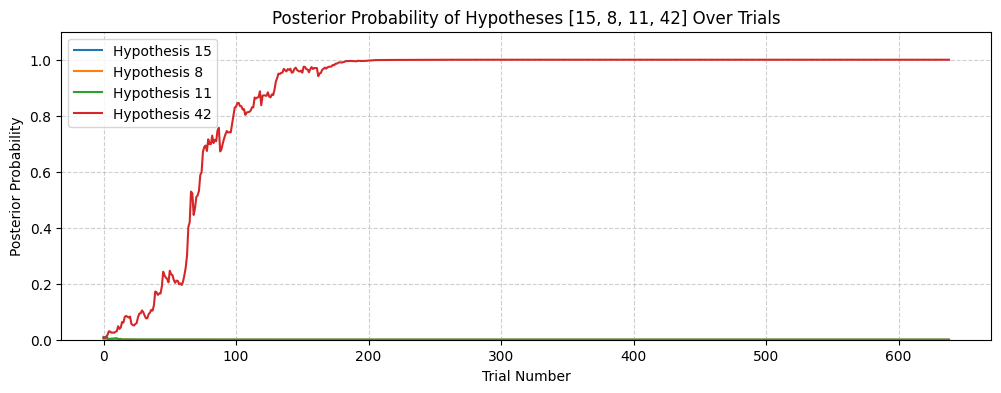

In [ ]:
# 画图

import matplotlib.pyplot as plt

def plot_hypo_posterior(posterior_log: list, hypo_indices: list, title: str = None):
    
    plt.figure(figsize=(12, 4))
    
    max_post_overall = 0
    
    # 遍历所有需要绘制的 hypothesis index
    for hypo_index in hypo_indices:
        hypo_posterior_over_time = [posterior[hypo_index] for posterior in posterior_log]
        
        # 找到所有曲线中的最大值，以统一y轴
        max_post = max(hypo_posterior_over_time)
        if max_post > max_post_overall:
            max_post_overall = max_post

        trials = np.arange(len(hypo_posterior_over_time))
        plt.plot(trials, hypo_posterior_over_time, linestyle='-', label=f'Hypothesis {hypo_index}')
    
    if title is None:
        title = f'Posterior Probability of Hypotheses {hypo_indices} Over Trials'
    plt.title(title)
    plt.xlabel('Trial Number')
    plt.ylabel('Posterior Probability')
    plt.ylim(0, max_post_overall * 1.1)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()


hypo_indices = [15, 8, 11, 42]
plot_hypo_posterior(results_state, hypo_indices=hypo_indices)